In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv


<h1>1. Import Library</h1>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import (accuracy_score, roc_auc_score, confusion_matrix, 
                             classification_report, roc_curve)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import shap
from plotly.subplots import make_subplots

<h1>2. Prepare Data</h1>

In [3]:
url = '/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv'
data = pd.read_csv(url)
data.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
# Lo·∫°i b·ªè c·ªôt kh√¥ng c·∫ßn thi·∫øt
if 'customerID' in data.columns:
    data.drop('customerID', axis=1, inplace=True)

In [6]:
data['TotalCharges'] = pd.to_numeric(data.TotalCharges, errors='coerce')
data.isnull().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

*  Khi ƒëi s√¢u v√†o d·ªØ li·ªáu, ch√∫ng ta nh·∫≠n th·∫•y r·∫±ng **`TotalCharges`** c√≥ nh·ªØng kho·∫£ng gi√° tr·ªã tr·∫Øng, thay v√¨ gi√° tr·ªã s·ªë ho·∫∑c `NaN`.  
ƒêi·ªÅu n√†y c√≥ th·ªÉ x·∫£y ra do l·ªói nh·∫≠p li·ªáu ho·∫∑c kho·∫£ng tr·∫Øng b·ªã ghi nh·∫≠n thay v√¨ gi√° tr·ªã th·ª±c.


In [7]:
data[data['tenure'] == 0].index

Index([488, 753, 936, 1082, 1340, 3331, 3826, 4380, 5218, 6670, 6754], dtype='int64')

In [8]:
data.drop(labels=data[data['tenure'] == 0]. index, axis=0, inplace=True)
data[data['tenure'] == 0].index

Index([], dtype='int64')

In [9]:
data.fillna(data["TotalCharges"].mean())

gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0     Female              0     Yes         No       1           No   
1       Male              0      No         No      34          Yes   
2       Male              0      No         No       2          Yes   
3       Male              0      No         No      45           No   
4     Female              0      No         No       2          Yes   
...      ...            ...     ...        ...     ...          ...   
7038    Male              0     Yes        Yes      24          Yes   
7039  Female              0     Yes        Yes      72          Yes   
7040  Female              0     Yes        Yes      11           No   
7041    Male              1     Yes         No       4          Yes   
7042    Male              0      No         No      66          Yes   

         MultipleLines InternetService OnlineSecurity OnlineBackup  \
0     No phone service             DSL             No          Yes   
1                   No             DSL            Yes           No   
2                   No             DSL            Yes          Yes   
3     No phone service             DSL            Yes           No   
4                   No     Fiber optic             No           No   
...                ...             ...            ...          ...   
7038               Yes             DSL            Yes           No   
7039               Yes     Fiber optic             No          Yes   
7040  No phone service             DSL            Yes           No   
7041               Yes     Fiber optic             No           No   
7042                No     Fiber optic            Yes           No   

     DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0                  No          No          No              No  Month-to-month   
1                 Yes          No          No              No        One year   
2                  No          No          No              No  Month-to-month   
3                 Yes         Yes          No              No        One year   
4                  No          No          No              No  Month-to-month   
...               ...         ...         ...             ...             ...   
7038              Yes         Yes         Yes             Yes        One year   
7039              Yes          No         Yes             Yes        One year   
7040               No          No          No              No  Month-to-month   
7041               No          No          No              No  Month-to-month   
7042              Yes         Yes         Yes             Yes        Two year   

     PaperlessBilling              PaymentMethod  MonthlyCharges  \
0                 Yes           Electronic check           29.85   
1                  No               Mailed check           56.95   
2                 Yes               Mailed check           53.85   
3                  No  Bank transfer (automatic)           42.30   
4                 Yes           Electronic check           70.70   
...               ...                        ...             ...   
7038              Yes               Mailed check           84.80   
7039              Yes    Credit card (automatic)          103.20   
7040              Yes           Electronic check           29.60   
7041              Yes               Mailed check           74.40   
7042              Yes  Bank transfer (automatic)          105.65   

      TotalCharges Churn  
0            29.85    No  
1          1889.50    No  
2           108.15   Yes  
3          1840.75    No  
4           151.65   Yes  
...            ...   ...  
7038       1990.50    No  
7039       7362.90    No  
7040        346.45    No  
7041        306.60   Yes  
7042       6844.50    No  

[7032 rows x 20 columns]

In [10]:
data.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [11]:
data["SeniorCitizen"]= data["SeniorCitizen"].map({0: "No", 1: "Yes"})
data.head()

gender SeniorCitizen Partner Dependents  tenure PhoneService  \
0  Female            No     Yes         No       1           No   
1    Male            No      No         No      34          Yes   
2    Male            No      No         No       2          Yes   
3    Male            No      No         No      45           No   
4  Female            No      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No          No              No  Month-to-month   
1              Yes          No          No              No        One year   
2               No          No          No              No  Month-to-month   
3              Yes         Yes          No              No        One year   
4               No          No          No              No  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges  TotalCharges  \
0              Yes           Electronic check           29.85         29.85   
1               No               Mailed check           56.95       1889.50   
2              Yes               Mailed check           53.85        108.15   
3               No  Bank transfer (automatic)           42.30       1840.75   
4              Yes           Electronic check           70.70        151.65   

  Churn  
0    No  
1    No  
2   Yes  
3    No  
4   Yes

In [12]:
g_labels = ['Male', 'Female']
c_labels = ['No', 'Yes']
# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=g_labels, values=data['gender'].value_counts(), name="Gender"),
              1, 1)
fig.add_trace(go.Pie(labels=c_labels, values=data['Churn'].value_counts(), name="Churn"),
              1, 2)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name", textfont_size=16)

fig.update_layout(
    title_text="Gender and Churn Distributions",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Gender', x=0.16, y=0.5, font_size=20, showarrow=False),
                 dict(text='Churn', x=0.84, y=0.5, font_size=20, showarrow=False)])
fig.show()

In [13]:
print(data.columns)


Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')


In [14]:
fig = px.histogram(data, x="Churn", color="Contract", barmode="group", title="<b>Customer contract distribution<b>")
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

In [15]:
labels = data['PaymentMethod'].unique()
values = data['PaymentMethod'].value_counts()

fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])
fig.update_layout(title_text="<b>Payment Method Distribution</b>")
fig.show()

In [16]:
fig = px.histogram(data, x="Churn", color="PaymentMethod", title="<b>Customer Payment Method distribution w.r.t. Churn</b>")
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

In [17]:
fig = go.Figure()

fig.add_trace(go.Bar(
  x = [['Churn:No', 'Churn:No', 'Churn:Yes', 'Churn:Yes'],
       ["Female", "Male", "Female", "Male"]],
  y = [965, 992, 219, 240],
  name = 'DSL',
))

fig.add_trace(go.Bar(
  x = [['Churn:No', 'Churn:No', 'Churn:Yes', 'Churn:Yes'],
       ["Female", "Male", "Female", "Male"]],
  y = [889, 910, 664, 633],
  name = 'Fiber optic',
))

fig.add_trace(go.Bar(
  x = [['Churn:No', 'Churn:No', 'Churn:Yes', 'Churn:Yes'],
       ["Female", "Male", "Female", "Male"]],
  y = [690, 717, 56, 57],
  name = 'No Internet',
))

fig.update_layout(title_text="<b>Churn Distribution w.r.t. Internet Service and Gender</b>")

fig.show()

In [18]:
color_map = {"Yes": "#FF97FF", "No": "#AB63FA"}
fig = px.histogram(data, x="Churn", color="Dependents", barmode="group", title="<b>Dependents distribution</b>", color_discrete_map=color_map)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

In [19]:
color_map = {"Yes": '#FFA15A', "No": '#00CC96'}
fig = px.histogram(data, x="Churn", color="Partner", barmode="group", title="<b>Chrun distribution w.r.t. Partners</b>", color_discrete_map=color_map)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

In [20]:
color_map = {"Yes": '#00CC96', "No": '#B6E880'}
fig = px.histogram(data, x="Churn", color="SeniorCitizen", title="<b>Chrun distribution w.r.t. Senior Citizen</b>", color_discrete_map=color_map)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

In [21]:
color_map = {"Yes": "#FF97FF", "No": "#AB63FA"}
fig = px.histogram(data, x="Churn", color="OnlineSecurity", barmode="group", title="<b>Churn w.r.t Online Security</b>", color_discrete_map=color_map)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

In [22]:
color_map = {"Yes": '#FFA15A', "No": '#00CC96'}
fig = px.histogram(data, x="Churn", color="PaperlessBilling",  title="<b>Chrun distribution w.r.t. Paperless Billing</b>", color_discrete_map=color_map)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

In [23]:
fig = px.histogram(data, x="Churn", color="TechSupport",barmode="group",  title="<b>Chrun distribution w.r.t. TechSupport</b>")
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

In [24]:
color_map = {"Yes": '#00CC96', "No": '#B6E880'}
fig = px.histogram(data, x="Churn", color="PhoneService", title="<b>Chrun distribution w.r.t. Phone Service</b>", color_discrete_map=color_map)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

<ipython-input-25-445dcfde850f>:2: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

<ipython-input-25-445dcfde850f>:4: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



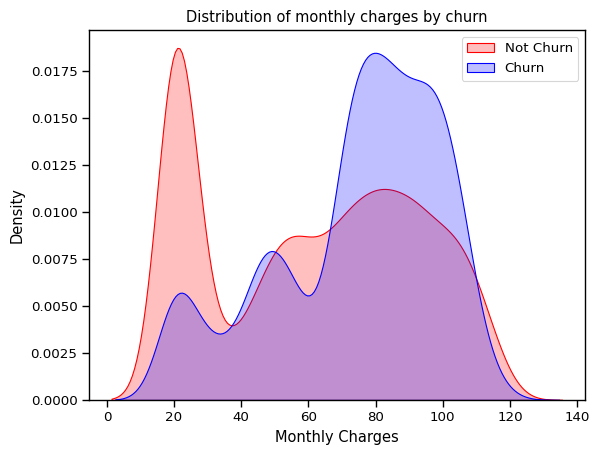

In [25]:
sns.set_context("paper",font_scale=1.1)
ax = sns.kdeplot(data.MonthlyCharges[(data["Churn"] == 'No') ],
                color="Red", shade = True);
ax = sns.kdeplot(data.MonthlyCharges[(data["Churn"] == 'Yes') ],
                ax =ax, color="Blue", shade= True);
ax.legend(["Not Churn","Churn"],loc='upper right');
ax.set_ylabel('Density');
ax.set_xlabel('Monthly Charges');
ax.set_title('Distribution of monthly charges by churn');

<ipython-input-26-08b2dccb725d>:1: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

<ipython-input-26-08b2dccb725d>:3: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



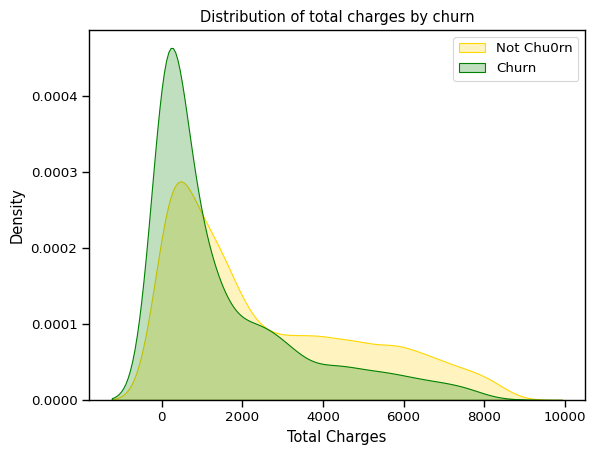

In [26]:
ax = sns.kdeplot(data.TotalCharges[(data["Churn"] == 'No') ],
                color="Gold", shade = True);
ax = sns.kdeplot(data.TotalCharges[(data["Churn"] == 'Yes') ],
                ax =ax, color="Green", shade= True);
ax.legend(["Not Chu0rn","Churn"],loc='upper right');
ax.set_ylabel('Density');
ax.set_xlabel('Total Charges');
ax.set_title('Distribution of total charges by churn');

In [27]:
fig = px.box(data, x='Churn', y = 'tenure')

# Update yaxis properties
fig.update_yaxes(title_text='Tenure (Months)', row=1, col=1)
# Update xaxis properties
fig.update_xaxes(title_text='Churn', row=1, col=1)

# Update size and title
fig.update_layout(autosize=True, width=750, height=600,
    title_font=dict(size=25, family='Courier'),
    title='<b>Tenure vs Churn</b>',
)

fig.show()

<h1>3. Modeling</h1>

In [28]:
data['Churn'] = data['Churn'].apply(lambda x: 1 if x=='Yes' else 0)

In [30]:
# One-hot encoding
categorical_features = data.select_dtypes(include=['object']).columns.tolist()
data = pd.get_dummies(data, columns=categorical_features, drop_first=True) 

In [31]:
X = data.drop('Churn', axis=1)
y = data['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


<h2>3.1. Logistic regression</h2>

In [32]:
models = {}

# --- 3.1 Logistic Regression ---
pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('lr', LogisticRegression(max_iter=1000, random_state=42))
])
param_dist_lr = {
    'lr__C': np.logspace(-3, 3, 100),  # Tham s·ªë C theo thang log
    'lr__penalty': ['l2'],
    'lr__solver': ['lbfgs']
}
rand_lr = RandomizedSearchCV(pipe_lr, param_distributions=param_dist_lr,
                             n_iter=20, scoring='roc_auc', cv=5,
                             random_state=42, n_jobs=-1)
rand_lr.fit(X_train, y_train)
print("Best parameters for Logistic Regression:", rand_lr.best_params_)
models['Logistic Regression'] = rand_lr.best_estimator_

Best parameters for Logistic Regression: {'lr__solver': 'lbfgs', 'lr__penalty': 'l2', 'lr__C': 46.41588833612782}


<h2>3.2. Random Forest</h2>

In [33]:
# --- 3.2 Random Forest ---
pipe_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42))
])
param_dist_rf = {
    'rf__n_estimators': [50, 100, 200, 300],
    'rf__max_depth': [None, 5, 10, 20],
    'rf__min_samples_split': [2, 5, 10]
}
rand_rf = RandomizedSearchCV(pipe_rf, param_distributions=param_dist_rf,
                             n_iter=20, scoring='roc_auc', cv=5,
                             random_state=42, n_jobs=-1)
rand_rf.fit(X_train, y_train)
print("Best parameters for Random Forest:", rand_rf.best_params_)
models['Random Forest'] = rand_rf.best_estimator_

Best parameters for Random Forest: {'rf__n_estimators': 300, 'rf__min_samples_split': 5, 'rf__max_depth': 5}


<h2>3.3. XGBoost</h2>

In [34]:
# --- 3.3 XGBoost ---
pipe_xgb = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('xgb', xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='auc'))
])
param_dist_xgb = {
    'xgb__n_estimators': [50, 100, 200, 300],
    'xgb__max_depth': [3, 5, 7, 10],
    'xgb__learning_rate': [0.01, 0.1, 0.2, 0.3]
}
rand_xgb = RandomizedSearchCV(pipe_xgb, param_distributions=param_dist_xgb,
                              n_iter=20, scoring='roc_auc', cv=5,
                              random_state=42, n_jobs=-1)
rand_xgb.fit(X_train, y_train)
print("Best parameters for XGBoost:", rand_xgb.best_params_)
models['XGBoost'] = rand_xgb.best_estimator_

Best parameters for XGBoost: {'xgb__n_estimators': 100, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.1}


<h2>3.4. Comparison </h2>


--- Logistic Regression ---
Accuracy: 0.733
AUC: 0.832
Confusion Matrix:
[[733 300]
 [ 75 299]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.71      0.80      1033
           1       0.50      0.80      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.71      1407
weighted avg       0.80      0.73      0.75      1407


--- Random Forest ---
Accuracy: 0.741
AUC: 0.834
Confusion Matrix:
[[749 284]
 [ 80 294]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.73      0.80      1033
           1       0.51      0.79      0.62       374

    accuracy                           0.74      1407
   macro avg       0.71      0.76      0.71      1407
weighted avg       0.80      0.74      0.75      1407


--- XGBoost ---
Accuracy: 0.770
AUC: 0.829
Confusion Matrix:
[[822 211]
 [113 261]]
Classification Report:
    

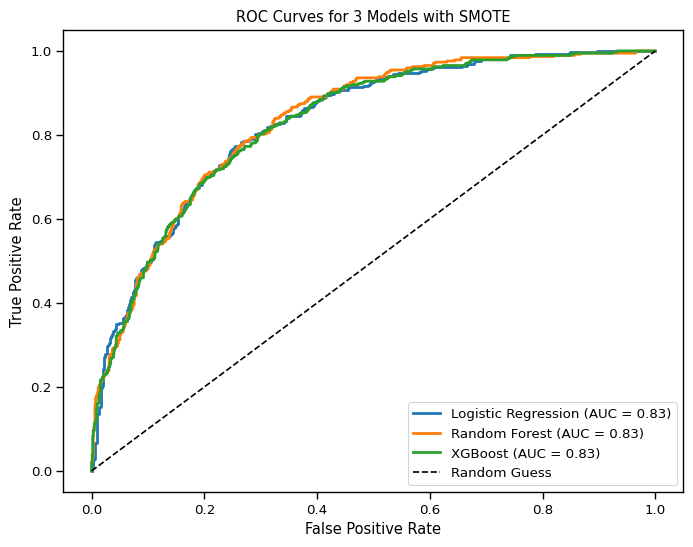

In [35]:
def evaluate_model(model, name, X_test, y_test):
    y_pred = model.predict(X_test)
    try:
        y_prob = model.predict_proba(X_test)[:, 1]
    except:
        y_prob = model.decision_function(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    auc_val = roc_auc_score(y_test, y_prob)
    
    print(f"\n--- {name} ---")
    print("Accuracy: {:.3f}".format(acc))
    print("AUC: {:.3f}".format(auc_val))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # V·∫Ω ROC curve cho m√¥ h√¨nh n√†y
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {auc_val:.2f})')
    
    evaluation_results.append({'Model': name, 'Accuracy': acc, 'AUC': auc_val})
evaluation_results = []
# V·∫Ω ROC curves cho c·∫£ 3 m√¥ h√¨nh
plt.figure(figsize=(8,6))
for name, model in models.items():
    evaluate_model(model, name, X_test, y_test)
plt.plot([0,1], [0,1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for 3 Models with SMOTE')
plt.legend(loc='lower right')
plt.show()


T√≥m t·∫Øt k·∫øt qu·∫£ ƒë√°nh gi√°:
                 Model  Accuracy       AUC
0  Logistic Regression  0.733475  0.831898
1        Random Forest  0.741294  0.833843
2              XGBoost  0.769723  0.829005

M√¥ h√¨nh ph√π h·ª£p nh·∫•t (d·ª±a tr√™n AUC):
Model       Random Forest
Accuracy         0.741294
AUC              0.833843
Name: 1, dtype: object


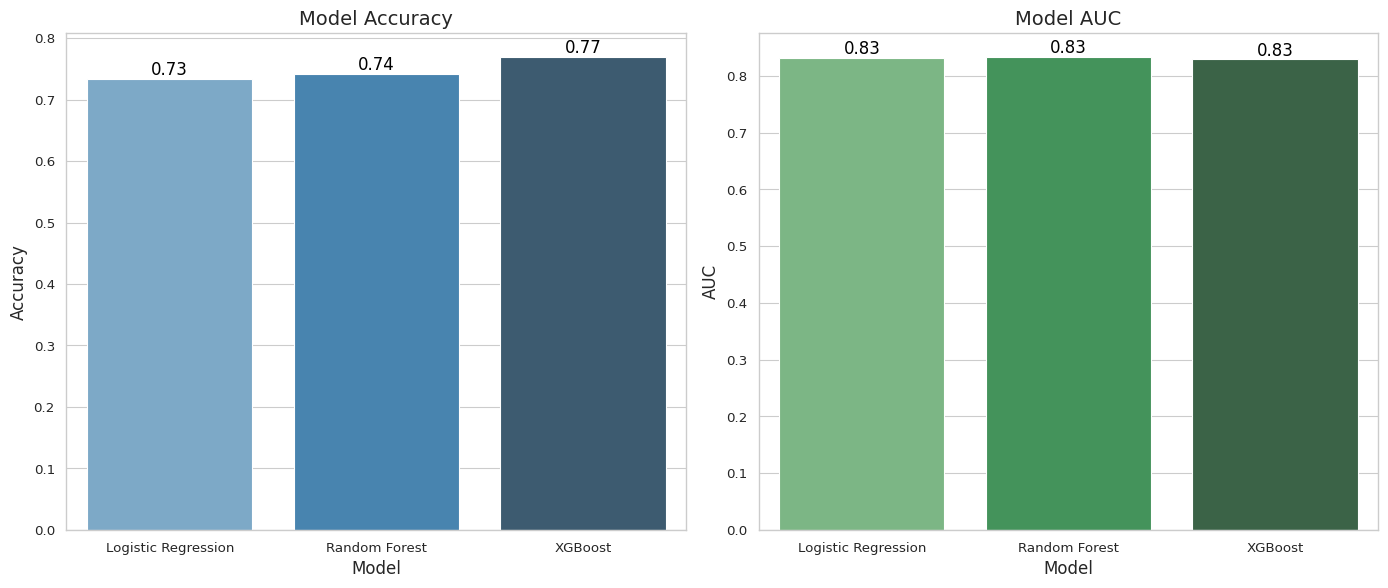

In [36]:
# Thi·∫øt l·∫≠p style cho bi·ªÉu ƒë·ªì
sns.set_style("whitegrid")

# ----------------------------
# 5. So s√°nh v√† hi·ªÉn th·ªã k·∫øt qu·∫£
# ----------------------------
# T·∫°o DataFrame ch·ª©a k·∫øt qu·∫£ ƒë√°nh gi√°
eval_df = pd.DataFrame(evaluation_results)
print("\nT√≥m t·∫Øt k·∫øt qu·∫£ ƒë√°nh gi√°:")
print(eval_df)

# X√°c ƒë·ªãnh m√¥ h√¨nh c√≥ AUC cao nh·∫•t
best_model = eval_df.loc[eval_df['AUC'].idxmax()]
print("\nM√¥ h√¨nh ph√π h·ª£p nh·∫•t (d·ª±a tr√™n AUC):")
print(best_model)

# V·∫Ω bi·ªÉu ƒë·ªì so s√°nh Accuracy v√† AUC gi·ªØa c√°c m√¥ h√¨nh
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Bi·ªÉu ƒë·ªì Accuracy
sns.barplot(data=eval_df, x='Model', y='Accuracy', ax=ax[0], palette='Blues_d')
ax[0].set_title('Model Accuracy', fontsize=14)
ax[0].set_ylabel('Accuracy', fontsize=12)
ax[0].set_xlabel('Model', fontsize=12)
# Annotation cho Accuracy
for p in ax[0].patches:
    height = p.get_height()
    ax[0].annotate(f'{height:.2f}', 
                   (p.get_x() + p.get_width()/2., height),
                   ha='center', va='bottom', fontsize=12, color='black')

# Bi·ªÉu ƒë·ªì AUC
sns.barplot(data=eval_df, x='Model', y='AUC', ax=ax[1], palette='Greens_d')
ax[1].set_title('Model AUC', fontsize=14)
ax[1].set_ylabel('AUC', fontsize=12)
ax[1].set_xlabel('Model', fontsize=12)
# Annotation cho AUC
for p in ax[1].patches:
    height = p.get_height()
    ax[1].annotate(f'{height:.2f}', 
                   (p.get_x() + p.get_width()/2., height),
                   ha='center', va='bottom', fontsize=12, color='black')

plt.tight_layout()
plt.show()


<h1>4. Feature Importance</h1>

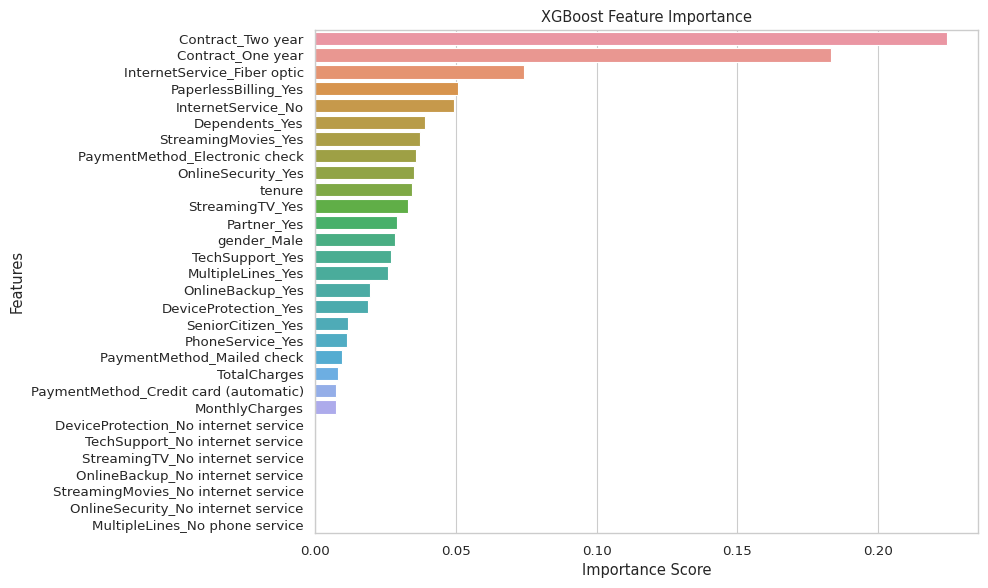

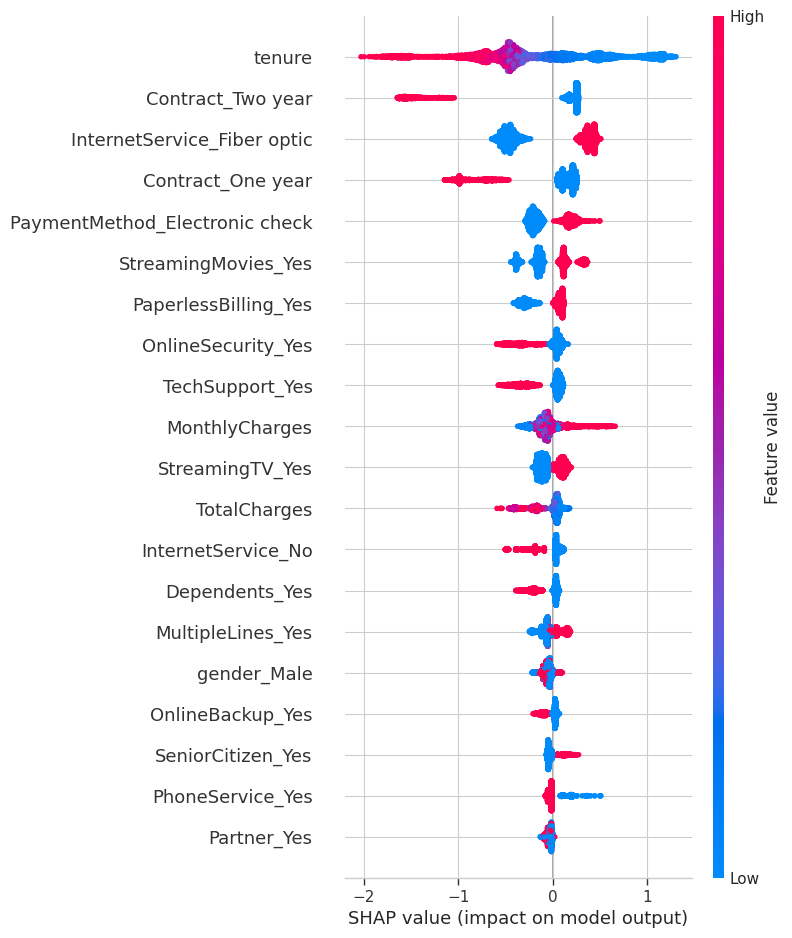

In [37]:
best_xgb = models['XGBoost']

xgb_model = best_xgb.named_steps['xgb']
scaler = best_xgb.named_steps['scaler']

X_train_scaled = scaler.transform(X_train)

# ----------------------------
# 1. Feature Importance t·ª´ XGBoost
# ----------------------------
importances = xgb_model.feature_importances_
# S·∫Øp x·∫øp theo th·ª© t·ª± gi·∫£m d·∫ßn
importance_series = pd.Series(importances, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=importance_series.values, y=importance_series.index)
plt.title("XGBoost Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

# ----------------------------
# 2. S·ª≠ d·ª•ng SHAP ƒë·ªÉ gi·∫£i th√≠ch m√¥ h√¨nh
# ----------------------------

# T·∫°o TreeExplainer cho XGBoost (l√†m vi·ªác v·ªõi d·ªØ li·ªáu ƒë√£ chu·∫©n h√≥a)
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train_scaled)

# T·∫°o DataFrame cho d·ªØ li·ªáu ƒë√£ chu·∫©n h√≥a ƒë·ªÉ hi·ªÉn th·ªã t√™n feature
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)

# V·∫Ω SHAP Summary Plot
shap.summary_plot(shap_values, X_train_scaled_df)


·ªû ƒë√¢y ch√∫ng ta c√≥ th·ªÉ th·∫•y 4 bi·∫øn l√† tenure, Contract_Two year, InternetService_Fiber optic, Contract_One year l√† c√°c bi·∫øn c√≥ t·∫ßm ·∫£nh h∆∞·ªüng quan tr·ªçng nh·∫•t ƒë·∫øn target c·ªßa ch√∫ng ta! H√£y c√πng nhau ph√¢n t√≠ch 4 bi·∫øn n√†y nh√©!


In [38]:
top_features = ['tenure','Contract_Two year', 'InternetService_Fiber optic', 'Contract_One year']
df_analysis = data[['Churn'] + top_features].copy()
df_analysis.head()

Churn  tenure  Contract_Two year  InternetService_Fiber optic  \
0      0       1              False                        False   
1      0      34              False                        False   
2      1       2              False                        False   
3      0      45              False                        False   
4      1       2              False                         True   

   Contract_One year  
0              False  
1               True  
2              False  
3               True  
4              False

In [39]:
group_stats = df_analysis.groupby('Churn')[top_features].agg(['mean', 'median', 'count'])
group_stats

tenure              Contract_Two year               \
            mean median count              mean median count   
Churn                                                          
0      37.650010   38.0  5163          0.317064    0.0  5163   
1      17.979133   10.0  1869          0.025682    0.0  1869   

      InternetService_Fiber optic              Contract_One year               
                             mean median count              mean median count  
Churn                                                                          
0                        0.348441    0.0  5163          0.252954    0.0  5163  
1                        0.693954    1.0  1869          0.088818    0.0  1869

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warn

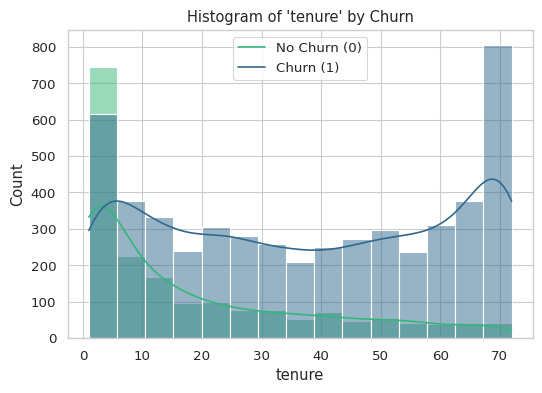

In [40]:
plt.figure(figsize=(6, 4))
sns.histplot(data=df_analysis, x='tenure', hue='Churn', palette='viridis', kde=True)
plt.title("Histogram of 'tenure' by Churn")
plt.legend(labels=['No Churn (0)', 'Churn (1)'])
plt.show()

## üîç Ph√¢n t√≠ch

> **Ph√¢n t√≠ch d·ªØ li·ªáu cho th·∫•y th·ªùi gian g·∫Øn b√≥ (Tenure) l√† y·∫øu t·ªë then ch·ªët trong vi·ªác d·ª± b√°o Churn.**

- **üìâ Tenure ng·∫Øn & Churn cao**
  - Kh√°ch h√†ng v·ªõi **tenure ng·∫Øn** c√≥ xu h∆∞·ªõng **r·ªùi b·ªè d·ªãch v·ª• (Churn)** v·ªõi t·ª∑ l·ªá cao.
  - ƒêi·ªÅu n√†y cho th·∫•y giai ƒëo·∫°n ƒë·∫ßu s·ª≠ d·ª•ng d·ªãch v·ª• l√† th·ªùi ƒëi·ªÉm r·ªßi ro l·ªõn.

- **üìà Tenure d√†i & Gi·ªØ ch√¢n kh√°ch h√†ng**
  - Kh√°ch h√†ng c√≥ **tenure d√†i** th∆∞·ªùng c√≥ kh·∫£ nƒÉng **gi·ªØ ch√¢n cao** v√† √≠t c√≥ kh·∫£ nƒÉng r·ªùi b·ªè d·ªãch v·ª•.
  - M·ªôt khi v∆∞·ª£t qua ƒë∆∞·ª£c giai ƒëo·∫°n ban ƒë·∫ßu, kh√°ch h√†ng c√≥ xu h∆∞·ªõng tr·ªü n√™n trung th√†nh h∆°n.

- **‚è∞ Giai ƒëo·∫°n ƒë·∫ßu quan tr·ªçng**
  - **Giai ƒëo·∫°n ƒë·∫ßu** (tenure ng·∫Øn) l√† th·ªùi ƒëi·ªÉm quy·∫øt ƒë·ªãnh ƒë·ªÉ **√°p d·ª•ng c√°c chi·∫øn l∆∞·ª£c gi·ªØ ch√¢n kh√°ch h√†ng**.
  - ƒê·∫ßu t∆∞ v√†o tr·∫£i nghi·ªám kh√°ch h√†ng, ∆∞u ƒë√£i ƒë·∫∑c bi·ªát v√† h·ªó tr·ª£ trong giai ƒëo·∫°n n√†y c√≥ th·ªÉ gi·∫£m thi·ªÉu r·ªßi ro churn ƒë√°ng k·ªÉ.

---

### üëâ L·ªùi khuy√™n chi·∫øn l∆∞·ª£c

- **T·∫≠p trung v√†o kh√°ch h√†ng m·ªõi:**  
  X√¢y d·ª±ng c√°c ch∆∞∆°ng tr√¨nh chƒÉm s√≥c v√† ∆∞u ƒë√£i ƒë·∫∑c bi·ªát cho kh√°ch h√†ng ·ªü giai ƒëo·∫°n ƒë·∫ßu nh·∫±m gi√∫p h·ªç v∆∞·ª£t qua kho·∫£ng th·ªùi gian r·ªßi ro.

- **Ch∆∞∆°ng tr√¨nh gi·ªØ ch√¢n:**  
  Ph√°t tri·ªÉn c√°c chi·∫øn l∆∞·ª£c d√†i h·∫°n ƒë·ªÉ tƒÉng th·ªùi gian g·∫Øn b√≥ c·ªßa kh√°ch h√†ng, ch·∫≥ng h·∫°n nh∆∞ ch∆∞∆°ng tr√¨nh kh√°ch h√†ng th√¢n thi·∫øt, gi·∫£m gi√° theo h·ª£p ƒë·ªìng d√†i h·∫°n, v.v.

- **Gi√°m s√°t & can thi·ªáp s·ªõm:**  
  Theo d√µi s√°t sao h√†nh vi c·ªßa kh√°ch h√†ng m·ªõi ƒë·ªÉ c√≥ c√°c bi·ªán ph√°p can thi·ªáp s·ªõm khi ph√°t hi·ªán d·∫•u hi·ªáu churn.



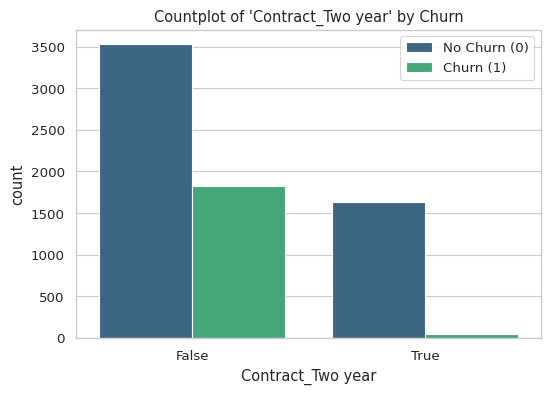

In [41]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df_analysis, x='Contract_Two year', hue='Churn', palette='viridis')
plt.title("Countplot of 'Contract_Two year' by Churn")
plt.legend(labels=['No Churn (0)', 'Churn (1)'])
plt.show()

## üîç Ph√¢n t√≠ch

---
### üìâ Kh√°ch h√†ng kh√¥ng c√≥ h·ª£p ƒë·ªìng hai nƒÉm & Churn cao

- **Kh√°ch h√†ng kh√¥ng c√≥ h·ª£p ƒë·ªìng hai nƒÉm** (`Contract_Two year = False`) c√≥ xu h∆∞·ªõng **r·ªùi b·ªè d·ªãch v·ª• (Churn)** v·ªõi t·ª∑ l·ªá cao h∆°n.
- ƒêi·ªÅu n√†y cho th·∫•y **s·ª± linh ho·∫°t ng·∫Øn h·∫°n** c√≥ th·ªÉ d·∫´n ƒë·∫øn **√≠t g·∫Øn b√≥ h∆°n** v·ªõi d·ªãch v·ª•.

---

### üìà H·ª£p ƒë·ªìng hai nƒÉm & Gi·ªØ ch√¢n kh√°ch h√†ng

- **Kh√°ch h√†ng c√≥ h·ª£p ƒë·ªìng hai nƒÉm** (`Contract_Two year = True`) th∆∞·ªùng c√≥ kh·∫£ nƒÉng **gi·ªØ ch√¢n cao** v√† √≠t c√≥ kh·∫£ nƒÉng r·ªùi b·ªè d·ªãch v·ª•.
- Cam k·∫øt d√†i h·∫°n cho th·∫•y s·ª± **trung th√†nh** v√† **h√†i l√≤ng cao** v·ªõi d·ªãch v·ª•.

---

### ‚è∞ Cam k·∫øt h·ª£p ƒë·ªìng quan tr·ªçng

- **Cam k·∫øt h·ª£p ƒë·ªìng**, ƒë·∫∑c bi·ªát l√† h·ª£p ƒë·ªìng hai nƒÉm, l√† y·∫øu t·ªë quy·∫øt ƒë·ªãnh ƒë·ªÉ **tƒÉng c∆∞·ªùng gi·ªØ ch√¢n kh√°ch h√†ng** v√† **gi·∫£m thi·ªÉu churn**.

---

## üëâ L·ªùi khuy√™n chi·∫øn l∆∞·ª£c

1. **Khuy·∫øn kh√≠ch h·ª£p ƒë·ªìng d√†i h·∫°n:**
   - **T·∫°o ∆∞u ƒë√£i v√† khuy·∫øn kh√≠ch** cho kh√°ch h√†ng ch·ªçn h·ª£p ƒë·ªìng hai nƒÉm ƒë·ªÉ tƒÉng c∆∞·ªùng cam k·∫øt v√† gi·∫£m churn.

2. **Ch∆∞∆°ng tr√¨nh gi·ªØ ch√¢n d·ª±a tr√™n h·ª£p ƒë·ªìng:**
   - Ph√°t tri·ªÉn c√°c ch∆∞∆°ng tr√¨nh gi·ªØ ch√¢n ƒë·∫∑c bi·ªát cho kh√°ch h√†ng c√≥ h·ª£p ƒë·ªìng d√†i h·∫°n, ch·∫≥ng h·∫°n nh∆∞ **∆∞u ƒë√£i ƒë·ªôc quy·ªÅn** ho·∫∑c **d·ªãch v·ª• n√¢ng cao**.

3. **T·∫≠p trung v√†o gi√° tr·ªã d√†i h·∫°n:**
   - **Truy·ªÅn ƒë·∫°t gi√° tr·ªã c·ªßa d·ªãch v·ª•** trong d√†i h·∫°n ƒë·ªÉ khuy·∫øn kh√≠ch kh√°ch h√†ng ch·ªçn c√°c g√≥i h·ª£p ƒë·ªìng d√†i h·∫°n.


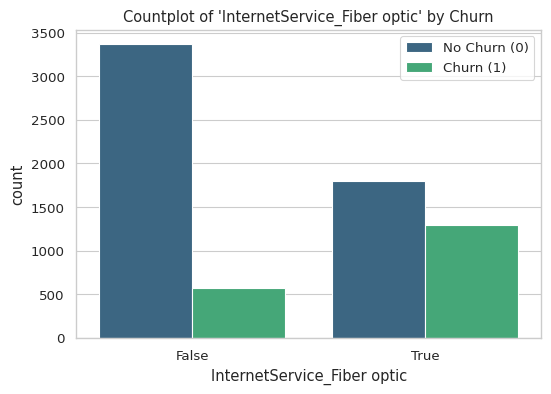

In [42]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df_analysis, x='InternetService_Fiber optic', hue='Churn', palette='viridis')
plt.title("Countplot of 'InternetService_Fiber optic' by Churn")
plt.legend(labels=['No Churn (0)', 'Churn (1)'])
plt.show()


## üîç Ph√¢n t√≠ch

---

### üìâ Kh√¥ng d√πng Fiber Optic & Churn th·∫•p

- **Kh√°ch h√†ng kh√¥ng s·ª≠ d·ª•ng d·ªãch v·ª• c√°p quang** (`InternetService_Fiber optic = False`) c√≥ xu h∆∞·ªõng **churn th·∫•p h∆°n**.
- ƒêi·ªÅu n√†y cho th·∫•y **d·ªãch v·ª• Internet kh√¥ng ph·∫£i c√°p quang** c√≥ kh·∫£ nƒÉng **gi·ªØ ch√¢n kh√°ch h√†ng t·ªët h∆°n**.

---

### üìà D√πng Fiber Optic & Churn cao

- **Kh√°ch h√†ng s·ª≠ d·ª•ng d·ªãch v·ª• c√°p quang** (`InternetService_Fiber optic = True`) c√≥ **t·ª∑ l·ªá churn cao h∆°n** so v·ªõi nh√≥m kh√¥ng s·ª≠ d·ª•ng.
- M·∫∑c d√π c√°p quang cung c·∫•p t·ªëc ƒë·ªô cao, nh∆∞ng n√≥ c√≥ th·ªÉ ƒëi k√®m v·ªõi **v·∫•n ƒë·ªÅ v·ªÅ ch·∫•t l∆∞·ª£ng d·ªãch v·ª•** ho·∫∑c **chi ph√≠ cao**, d·∫´n ƒë·∫øn vi·ªác kh√°ch h√†ng d·ªÖ r·ªùi b·ªè.

---

### ‚è∞ D·ªãch v·ª• Fiber Optic c·∫ßn quan t√¢m

- **D·ªãch v·ª• c√°p quang** l√† m·ªôt y·∫øu t·ªë c·∫ßn ƒë∆∞·ª£c xem x√©t k·ªπ l∆∞·ª°ng trong chi·∫øn l∆∞·ª£c gi·∫£m thi·ªÉu churn.
- **C·∫ßn t√¨m hi·ªÉu nguy√™n nh√¢n** ƒë·∫±ng sau t·ª∑ l·ªá churn cao ·ªü nh√≥m kh√°ch h√†ng s·ª≠ d·ª•ng d·ªãch v·ª• c√°p quang.

---

## üëâ L·ªùi khuy√™n chi·∫øn l∆∞·ª£c

1. **T√¨m hi·ªÉu nguy√™n nh√¢n churn c√°p quang:**
   - Nghi√™n c·ª©u k·ªπ l∆∞·ª°ng c√°c l√Ω do kh√°ch h√†ng s·ª≠ d·ª•ng c√°p quang r·ªùi b·ªè d·ªãch v·ª•.
   - Xem x√©t c√°c y·∫øu t·ªë nh∆∞ **gi√° c·∫£**, **ch·∫•t l∆∞·ª£ng d·ªãch v·ª• kh√¥ng ·ªïn ƒë·ªãnh**, **s·ª± c·∫°nh tranh** v√† **k·ª≥ v·ªçng c·ªßa kh√°ch h√†ng**.

2. **C·∫£i thi·ªán tr·∫£i nghi·ªám d·ªãch v·ª• c√°p quang:**
   - **N√¢ng cao ch·∫•t l∆∞·ª£ng v√† ƒë·ªô ·ªïn ƒë·ªãnh** c·ªßa d·ªãch v·ª•.
   - ƒê·∫£m b·∫£o **gi√° c·∫£ c·∫°nh tranh** v√† ph√π h·ª£p v·ªõi gi√° tr·ªã d·ªãch v·ª• mang l·∫°i.
   - Cung c·∫•p **h·ªó tr·ª£ k·ªπ thu·∫≠t chuy√™n nghi·ªáp v√† nhanh ch√≥ng** cho kh√°ch h√†ng s·ª≠ d·ª•ng d·ªãch v·ª• c√°p quang.

3. **T·∫≠p trung v√†o gi·ªØ ch√¢n kh√°ch h√†ng c√°p quang:**
   - Ph√°t tri·ªÉn c√°c **ch∆∞∆°ng tr√¨nh chƒÉm s√≥c kh√°ch h√†ng ƒë·∫∑c bi·ªát** cho nh√≥m kh√°ch h√†ng s·ª≠ d·ª•ng c√°p quang nh·∫±m tƒÉng s·ª± h√†i l√≤ng v√† l√≤ng trung th√†nh.
   - **Thu th·∫≠p ph·∫£n h·ªìi th∆∞·ªùng xuy√™n** t·ª´ kh√°ch h√†ng ƒë·ªÉ li√™n t·ª•c c·∫£i thi·ªán d·ªãch v·ª• v√† ƒë√°p ·ª©ng nhu c·∫ßu c·ªßa h·ªç.


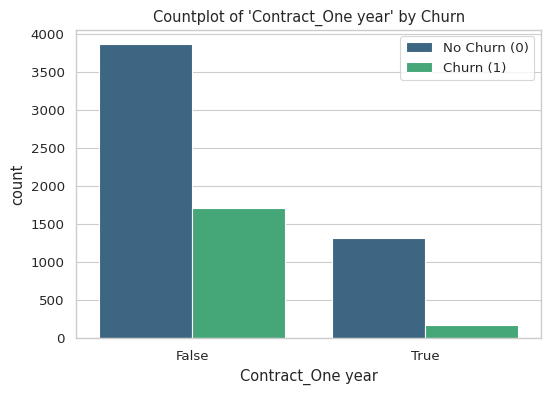

In [43]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df_analysis, x='Contract_One year', hue='Churn', palette='viridis')
plt.title("Countplot of 'Contract_One year' by Churn")
plt.legend(labels=['No Churn (0)', 'Churn (1)'])
plt.show()

## üîç Ph√¢n t√≠ch
---

### üìâ Kh√¥ng h·ª£p ƒë·ªìng m·ªôt nƒÉm & Churn cao

- **Kh√°ch h√†ng kh√¥ng c√≥ h·ª£p ƒë·ªìng m·ªôt nƒÉm** (`Contract_One year = False`) c√≥ xu h∆∞·ªõng **r·ªùi b·ªè d·ªãch v·ª• (Churn) v·ªõi t·ª∑ l·ªá cao h∆°n ƒë√°ng k·ªÉ**.
- ƒêi·ªÅu n√†y cho th·∫•y **s·ª± thi·∫øu cam k·∫øt h·ª£p ƒë·ªìng** c√≥ th·ªÉ d·∫´n ƒë·∫øn **t·ª∑ l·ªá churn cao**.

---

### üìà H·ª£p ƒë·ªìng m·ªôt nƒÉm & Gi·ªØ ch√¢n kh√°ch h√†ng

- **Kh√°ch h√†ng c√≥ h·ª£p ƒë·ªìng m·ªôt nƒÉm** (`Contract_One year = True`) c√≥ t·ª∑ l·ªá **gi·ªØ ch√¢n cao** v√† **√≠t c√≥ kh·∫£ nƒÉng r·ªùi b·ªè d·ªãch v·ª•**.
- Cam k·∫øt h·ª£p ƒë·ªìng m·ªôt nƒÉm th·ªÉ hi·ªán s·ª± **g·∫Øn b√≥** v√† **gi·∫£m thi·ªÉu r·ªßi ro churn**.

---

### ‚è∞ H·ª£p ƒë·ªìng m·ªôt nƒÉm quan tr·ªçng

- **H·ª£p ƒë·ªìng m·ªôt nƒÉm** ƒë√≥ng vai tr√≤ then ch·ªët trong vi·ªác **gi·ªØ ch√¢n kh√°ch h√†ng** v√† **gi·∫£m t·ª∑ l·ªá churn**.
- Khuy·∫øn kh√≠ch kh√°ch h√†ng k√Ω h·ª£p ƒë·ªìng m·ªôt nƒÉm c√≥ th·ªÉ l√† **m·ªôt chi·∫øn l∆∞·ª£c hi·ªáu qu·∫£**.

---

## üëâ L·ªùi khuy√™n chi·∫øn l∆∞·ª£c

1. **Khuy·∫øn kh√≠ch h·ª£p ƒë·ªìng m·ªôt nƒÉm:**
   - T·∫°o ƒë·ªông l·ª±c v√† ∆∞u ƒë√£i ƒë·ªÉ kh√°ch h√†ng l·ª±a ch·ªçn h·ª£p ƒë·ªìng m·ªôt nƒÉm.
   - V√≠ d·ª•: **gi·∫£m gi√°**, **qu√† t·∫∑ng** ho·∫∑c c√°c **l·ª£i √≠ch ƒë·ªôc quy·ªÅn** khi k√Ω h·ª£p ƒë·ªìng d√†i h·∫°n.

2. **T·∫≠n d·ª•ng h·ª£p ƒë·ªìng m·ªôt nƒÉm cho ch∆∞∆°ng tr√¨nh gi·ªØ ch√¢n:**
   - X√¢y d·ª±ng c√°c ch∆∞∆°ng tr√¨nh chƒÉm s√≥c v√† gi·ªØ ch√¢n kh√°ch h√†ng t·∫≠p trung v√†o nh√≥m c√≥ h·ª£p ƒë·ªìng m·ªôt nƒÉm.
   - √Åp d·ª•ng c√°c ch∆∞∆°ng tr√¨nh nh∆∞ **kh√°ch h√†ng th√¢n thi·∫øt** ho·∫∑c **∆∞u ƒë√£i gia h·∫°n h·ª£p ƒë·ªìng**.

3. **Truy·ªÅn th√¥ng v·ªÅ l·ª£i √≠ch c·ªßa h·ª£p ƒë·ªìng:**
   - Nh·∫•n m·∫°nh c√°c **l·ª£i √≠ch c·ªßa vi·ªác k√Ω h·ª£p ƒë·ªìng m·ªôt nƒÉm**, nh∆∞ **gi√° ·ªïn ƒë·ªãnh**, **d·ªãch v·ª• li√™n t·ª•c** v√† **∆∞u ƒë√£i ƒë·∫∑c bi·ªát**.
   - ƒêi·ªÅu n√†y gi√∫p khuy·∫øn kh√≠ch kh√°ch h√†ng ch·ªçn l·ª±a h√¨nh th·ª©c h·ª£p ƒë·ªìng m·ªôt nƒÉm, t·∫°o ra gi√° tr·ªã l√¢u d√†i.

---


<h1>5. Modeling With Features Importance</h1>

In [44]:
top_4_features = ['tenure','Contract_Two year', 'InternetService_Fiber optic', 'Contract_One year']

X_train_top4 = X_train[top_4_features]
X_test_top4 = X_test[top_4_features]

pipe_xgb_top4 = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('xgb', xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='auc'))
])

# S·ª≠ d·ª•ng c√πng param_dist_xgb ƒë√£ ƒë·ªãnh nghƒ©a tr∆∞·ªõc ƒë√≥
rand_xgb_top4 = RandomizedSearchCV(pipe_xgb_top4, param_distributions=param_dist_xgb,
                                   n_iter=20, scoring='roc_auc', cv=5,
                                   random_state=42, n_jobs=-1)
rand_xgb_top4.fit(X_train_top4, y_train)
print("Best parameters for XGBoost (Top 4 Features):", rand_xgb_top4.best_params_)

# L∆∞u m√¥ h√¨nh hu·∫•n luy·ªán v·ªõi 3 bi·∫øn v√†o dictionary
models['XGBoost_top4'] = rand_xgb_top4.best_estimator_


Best parameters for XGBoost (Top 4 Features): {'xgb__n_estimators': 300, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.01}



--- XGBoost Full ---
Accuracy: 0.770
AUC: 0.829
Confusion Matrix:
[[822 211]
 [113 261]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.80      0.84      1033
           1       0.55      0.70      0.62       374

    accuracy                           0.77      1407
   macro avg       0.72      0.75      0.73      1407
weighted avg       0.79      0.77      0.78      1407


--- XGBoost Top 4 ---
Accuracy: 0.721
AUC: 0.818
Confusion Matrix:
[[727 306]
 [ 86 288]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.70      0.79      1033
           1       0.48      0.77      0.60       374

    accuracy                           0.72      1407
   macro avg       0.69      0.74      0.69      1407
weighted avg       0.79      0.72      0.74      1407



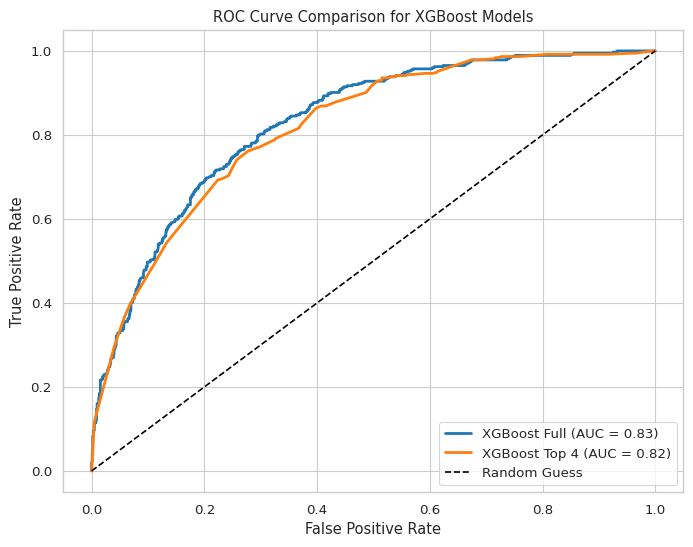

In [45]:
plt.figure(figsize=(8,6))
evaluate_model(models['XGBoost'], "XGBoost Full", X_test, y_test)

evaluate_model(models['XGBoost_top4'], "XGBoost Top 4", X_test[top_4_features], y_test)

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison for XGBoost Models')
plt.legend(loc='lower right')
plt.show()